# Modeler Notebook Analysis of Magnetospheric State Query System (MSQS) data
Relies on importing mlr_code.py instead of the analysis_notebook standalone  
Any changes to the code in mlr_code.py are reflected in this file AFTER RESTARTING KERNEL  
tester.ipynb, mlr_code.py, and extra_funcs.py MUST ALL BE IN THE SAME DIRECTORY

In [20]:
from mlr_code import import_data, MLR # Import local mlr_code file and functions from file

import pandas as pd # For store and organize data as pandas databases
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt # For plotting data
import seaborn as sns # Alternative way of plotting data
from datetime import datetime, time # For converting individual dates, times, and hours to an easily (pandas/matplotlib) readable datetime format

pd.options.mode.chained_assignment = None # Default to "warn"; To disable the warning caused by chained index calls on pandas series/databases

### Configurable model options
MATCH - Response variable to determine coefficients for (between Kp, AE, and Dst)  
CHANGE_MODEL_SIZE_THRESHOLD - For the sample size above the threshold, the machine learning linear regression estimation is used, otherwise, the arithmetic mean estimation is used  
time_shifts - The corresponding time shifts for each input parameter given the response parameter  
training_data_interval, testing_data_interval - The time intervals to run as training and testing data

In [2]:
MATCH = 'Kp (n/a)' # from 'Kp (n/a)','AE (hourly) (nT)', or 'Dst (nT)'
CHANGE_MODEL_SIZE_THRESHOLD = 80
time_shifts = {
    'Kp (n/a)': { # For response parameter Kp
        'SW Flow Pressure (nPa)': 0, # Default 0 hours
        'SW Bmag (nT)': 0, # 0 hours
        'SW Bz (nT)': 1, # 1 hour
        'SW Velocity (km/sec)': 0, # 0 hours
        'Kp (n/a)': 0, # 0 hours
        'AE (hourly) (nT)': 0 # 0 hours
    },
    'AE (hourly) (nT)': { # For response parameter AE
        'SW Flow Pressure (nPa)': 0, # Default 0 hours
        'SW Bmag (nT)': 0, # 0 hours
        'SW Bz (nT)': 1, # 1 hour
        'SW Velocity (km/sec)': 0, # 0 hours
        'Kp (n/a)': 0, # 0 hours
        'AE (hourly) (nT)': 0 # 0 hours
    },
    'Dst (nT)': { # For response parameter Dst
        'SW Flow Pressure (nPa)': 2, # Default 2 hours
        'SW Bmag (nT)': 2, # 2 hours
        'SW Bz (nT)': 3, # 3 hours
        'SW Velocity (km/sec)': 2, # 2 hours
        'Kp (n/a)': 2, # 2 hours
        'AE (hourly) (nT)': 2 # 2 hours
    }
}
training_data_interval = (datetime(1970, 1, 1, 1, 0),datetime(1996, 6, 11, 3, 0)) # Configurable datetime(year, month, day, hour, min)
testing_data_interval = (datetime(1996, 6, 11, 3, 0),datetime(2018, 6, 30, 23, 0)) # Configurable datetime(year, month, day, hour, min)

### Import data from CSV
Extract data from local csv file (must be in same directory as this file)  
Time shifts the data appropriately given a time shift dictionary and the match variable to determine which time shifts to use

In [3]:
data = import_data('omni2_h8ZIWOAzck.csv', MATCH, time_shifts) # file_name, match variable, time_shift dictionary

### Split training and testing data
Splits data into train and test according to the time intervals specified by the model configuration above  
The time interval is currently set to inclusive beginning time and exclusive ending time, but this may be changed  
These intervals can overlap

In [4]:
# Split data within the training and testing time intervals specified
# Inclusive beginning time to exclusive ending time (modifiable)
training_data = data[(data['datetime'] >= training_data_interval[0]) & (data['datetime'] < training_data_interval[1])]
testing_data = data[(data['datetime'] >= testing_data_interval[0]) & (data['datetime'] < testing_data_interval[1])]

### Machine learning model
Use the multiple linear regression model by sklearn to extract prediction data for both training and testing and also the learned linear coefficient data

In [5]:
# Run multiple linear regression model and extract coefficients dataframe, resulting training dataframe with predictions, and resulting testing dataframe with predictions
coeff_df, training_data, testing_data = MLR(training_data, testing_data, MATCH, CHANGE_MODEL_SIZE_THRESHOLD)

## Results
### Training data and testing data dataframes

In [6]:
training_data

,Year,Decimal Day,hour:min,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),datetime,Kp (n/a) est,Kp (n/a) diff
1,1970,1,1,1.12,3.3,-0.2,332,0.7,26,5,1970-01-01 01:00:00,0.744473,-0.044473
2,1970,1,2,1.12,2.5,1.9,332,0.7,34,8,1970-01-01 02:00:00,0.610866,0.089134
3,1970,1,3,1.17,4.5,1.6,321,2.0,37,9,1970-01-01 03:00:00,0.649116,1.350884
4,1970,1,4,1.17,4.5,-1.2,321,2.0,78,8,1970-01-01 04:00:00,1.114645,0.885355
5,1970,1,5,1.17,6.3,-3.4,321,2.0,137,4,1970-01-01 05:00:00,1.970318,0.029682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231790,1996,162,22,1.63,3.9,-0.4,350,0.7,45,-5,1996-06-10 22:00:00,1.154602,-0.454602
231791,1996,162,23,1.58,3.8,1.6,344,0.7,49,-1,1996-06-10 23:00:00,0.80062,-0.10062
231792,1996,163,0,1.5,3.3,2.5,343,0.3,47,4,1996-06-11 00:00:00,0.639203,-0.339203
231793,1996,163,1,1.43,3.7,2.5,340,0.3,39,6,1996-06-11 01:00:00,0.657663,-0.357663


In [7]:
testing_data

,Year,Decimal Day,hour:min,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),datetime,Kp (n/a) est,Kp (n/a) diff
231795,1996,163,3,1.52,3.4,0.3,338,1.0,64,3,1996-06-11 03:00:00,0.786704,0.213296
231796,1996,163,4,1.58,2.8,-0.1,339,1.0,58,6,1996-06-11 04:00:00,0.769511,0.230489
231797,1996,163,5,1.99,4.0,-0.4,341,1.0,57,7,1996-06-11 05:00:00,1.185704,-0.185704
231798,1996,163,6,2.53,3.7,1.1,344,1.0,67,11,1996-06-11 06:00:00,1.138514,-0.138514
231799,1996,163,7,2.84,3.2,1.5,352,1.0,144,13,1996-06-11 07:00:00,1.197282,-0.197282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425106,2018,181,18,1.05,3.8,1.9,436,0.7,44,-5,2018-06-30 18:00:00,1.103126,-0.403126
425107,2018,181,19,1.2,3.3,2.5,460,0.7,44,-6,2018-06-30 19:00:00,1.18383,-0.48383
425108,2018,181,20,1.08,3.4,-1.9,454,0.7,62,-7,2018-06-30 20:00:00,2.18545,-1.48545
425109,2018,181,21,0.93,3.7,0.2,451,1.0,114,-10,2018-06-30 21:00:00,1.275243,-0.275243


### Linear coefficients dataframe
The columns with the input parameters represent the bin indices for a coefficient set  
The arithmetic mean of the output parameters for the data in that bin combination as well as the number of entries fitting with that bin combination are included

In [8]:
# Dataframe storing the coefficients for each bin combination (a bin interval of -1 is (-inf,inf))
coeff_df

,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),SW Flow Pressure (nPa) coeff,SW Bmag (nT) coeff,SW Bz (nT) coeff,SW Velocity (km/sec) coeff,intercept,arithmetic_mean,model_size
0,0,0,2,0,-1,-1,-1,-17.125537,0.206374,0.007875,0.027988,-0.147204,0.725,8
1,0,0,2,1,-1,-1,-1,-2.532522,0.52729,-0.276734,-0.004109,1.628952,0.555556,27
2,0,0,2,2,-1,-1,-1,1.591501,0.329289,-1.501563,0.011489,-5.971972,0.941667,12
3,0,0,2,3,-1,-1,-1,0.0,0.0,0.0,0.0,1.7,1.7,1
4,0,0,3,0,-1,-1,-1,0.049616,0.297914,-0.06976,-0.010496,2.851688,0.7375,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,6,4,5,1,-1,-1,-1,0.000599,-0.000705,-0.010902,-0.039774,18.881896,3.666667,3
743,6,4,5,2,-1,-1,-1,-0.078847,0.305564,0.002121,0.040084,-20.803915,3.4,4
744,6,4,5,3,-1,-1,-1,-0.01785,-0.015985,0.001332,0.062164,-29.534807,5.0,2
745,6,4,5,4,-1,-1,-1,-0.164259,-0.011652,0.059555,0.003112,7.978559,6.94,5


### Number of valid testing data estimates
Number of entries with a valid estimation for the response parameter vs number of entries with no data for that bin combination to make an estimate

In [9]:
# (# entries with a valid estimation for the response parameter, # entries with no estimation)
testing_data[testing_data[MATCH + ' est'].notnull()].shape[0], testing_data[testing_data[MATCH + ' est'].isnull()].shape[0]

(187888, 360)

### Testing data sorted by increasing estimation error

In [10]:
# Sorted by increasing estimation error
testing_data[testing_data[MATCH + ' est'].notnull()].reindex(testing_data[testing_data[MATCH + ' est'].notnull()][MATCH + ' diff'].abs().sort_values().index)

,Year,Decimal Day,hour:min,SW Flow Pressure (nPa),SW Bmag (nT),SW Bz (nT),SW Velocity (km/sec),Kp (n/a),AE (hourly) (nT),Dst (nT),datetime,Kp (n/a) est,Kp (n/a) diff
250821,1998,224,21,1.25,0.9,5.7,418,3.0,68,1,1998-08-12 21:00:00,3.0,0.0
366538,2011,298,10,0.83,23.5,8.6,451,3.0,219,-79,2011-10-25 10:00:00,3.0,0.0
402959,2015,354,23,0.64,19.5,-17.9,422,6.3,479,-161,2015-12-20 23:00:00,6.3,0.0
372883,2012,197,19,1.41,21.4,-16.2,537,7.0,951,-127,2012-07-15 19:00:00,7.0,0.0
304175,2004,256,23,0.16,10.2,2.4,255,0.3,29,3,2004-09-12 23:00:00,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310043,2005,135,11,4.99,50.0,21.9,961,7.7,349,-175,2005-05-15 11:00:00,2.8,4.9
307230,2005,18,6,0.84,9.4,13.5,556,7.7,489,-55,2005-01-18 06:00:00,2.615714,5.084286
265287,2000,97,15,1.74,6.2,0.4,368,6.7,185,-21,2000-04-06 15:00:00,1.518307,5.181693
303021,2004,208,21,1.18,3.8,1.1,595,7.3,195,-42,2004-07-26 21:00:00,2.112348,5.187652


### Mean squared error of actual vs predicted values

In [11]:
# mean squared error between actual response values vs predicted response values (smaller = more accurate)
mean_squared_error(testing_data[testing_data[MATCH + ' est'].notnull()][MATCH].astype('float64'),testing_data[testing_data[MATCH + ' est'].notnull()][MATCH + ' est'].astype('float64'))

0.5544253599591098

### Mean and standard deviation of the difference between actual and predicted values

In [12]:
# Compute the mean of the error difference and the standard deviation of the error
testing_data[MATCH + ' diff'].mean(), testing_data[MATCH + ' diff'].std()

(-0.19535171729636552, 0.7185163980315089)

### Error distribution

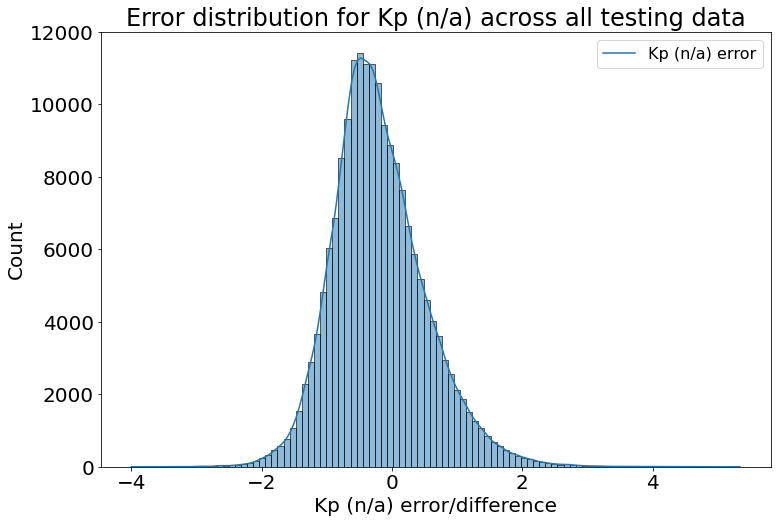

In [13]:
plt.figure(figsize=(12,8))
sns.histplot(testing_data[MATCH + ' diff'], kde=True, bins=100)
plt.legend([MATCH + ' error'])

#plt.xlim((-100,100))

plt.xlabel(MATCH + ' error/difference')
plt.title('Error distribution for '+MATCH+' across all testing data')
plt.show()

### Configurable datetime range graphs

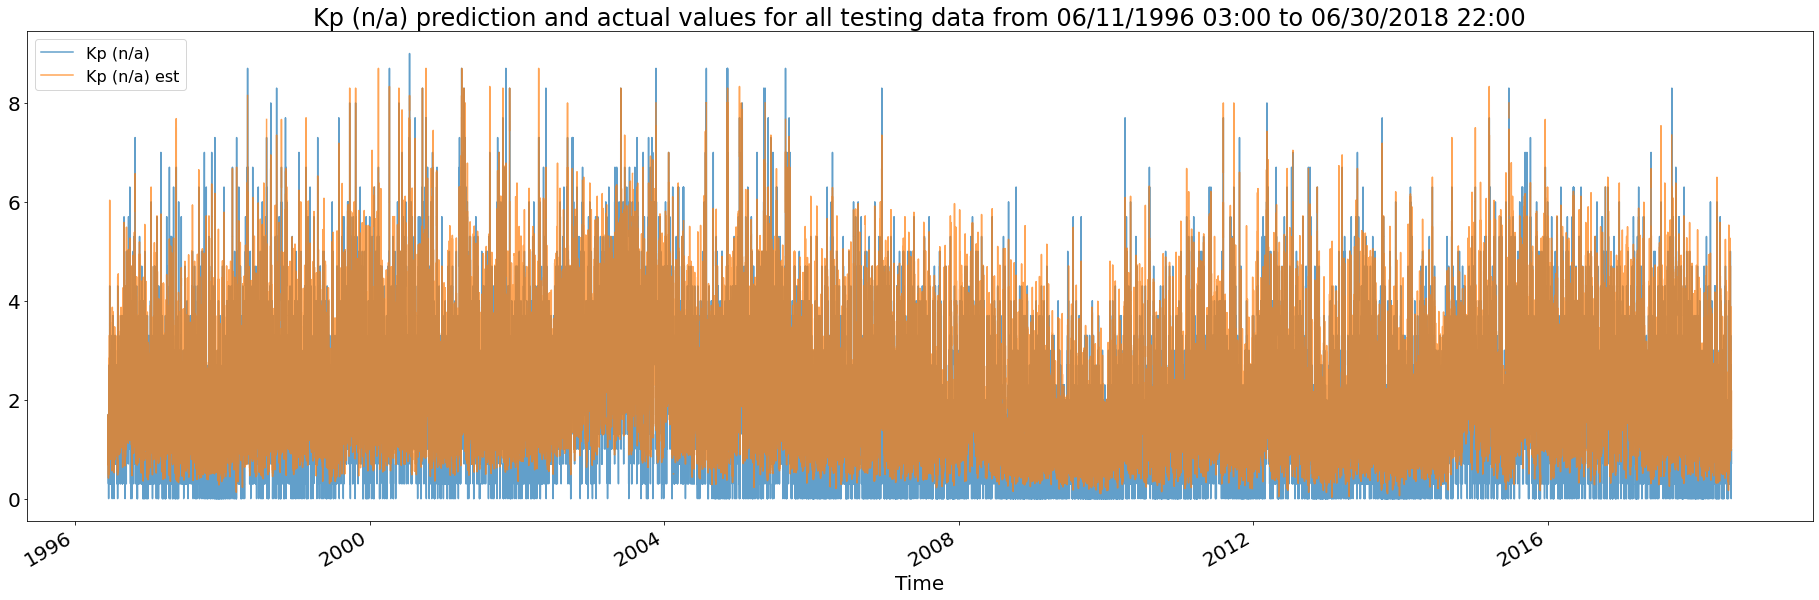

In [14]:
plt.figure(figsize=(32,10))

# alpha to set opacity
testing_data.set_index('datetime')[MATCH].plot(alpha=0.7)
testing_data.set_index('datetime')[MATCH + ' est'].plot(alpha=0.7)

#plt.ylim((-500,500))

plt.xlabel('Time')
plt.title(MATCH + ' prediction and actual values for all testing data from '+testing_data['datetime'].iloc[0].strftime('%m/%d/%Y %H:%M')+' to '+testing_data['datetime'].iloc[-1].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

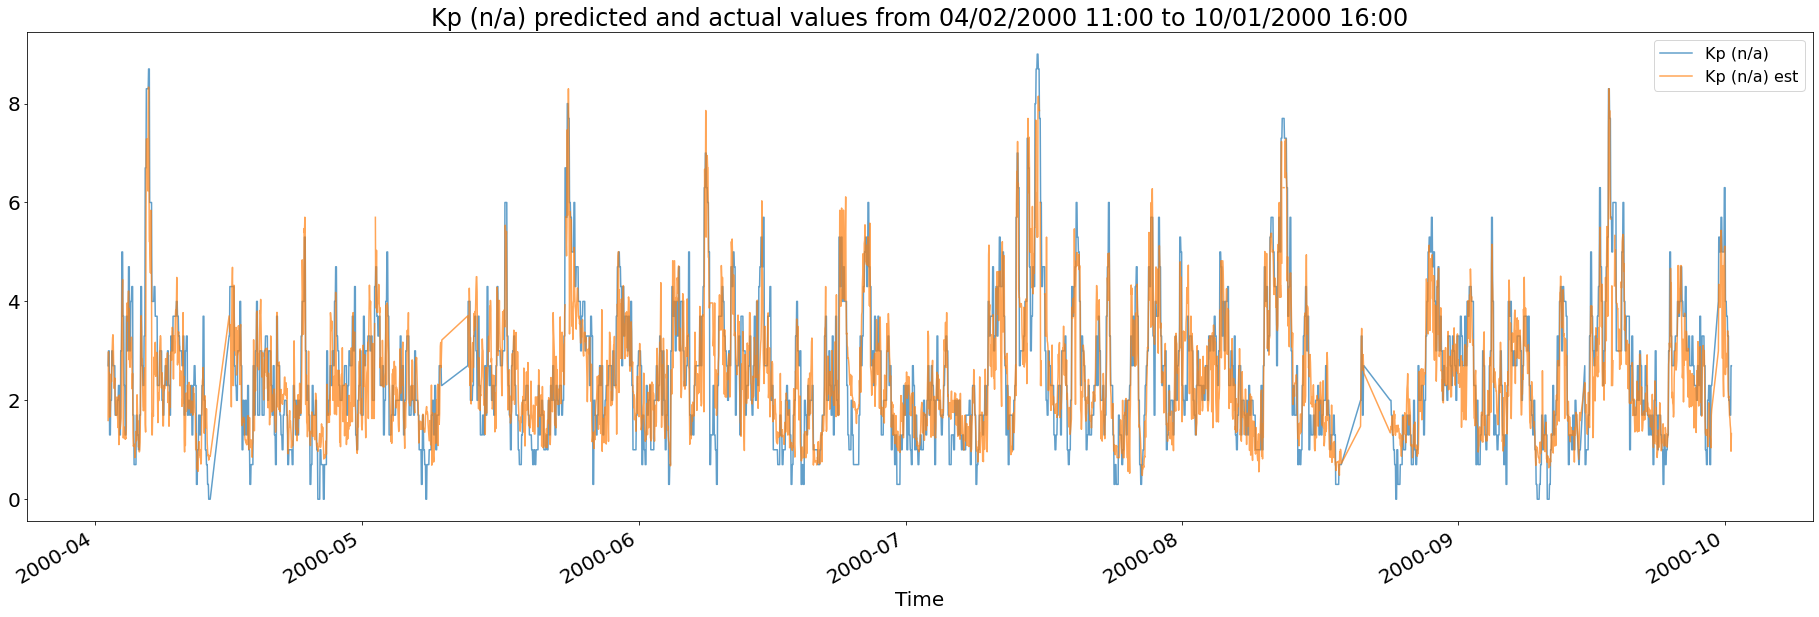

In [15]:
plt.figure(figsize=(32,10))

time_interval = (datetime(2000, 4, 2, 11, 0),datetime(2000, 10, 1, 16, 0)) # Configurable datetime(year, month, day, hour, min)
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

testing_data.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7) # alpha to set opacity
testing_data.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-320,100))

plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+time_interval[0].strftime('%m/%d/%Y %H:%M')+' to '+time_interval[1].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

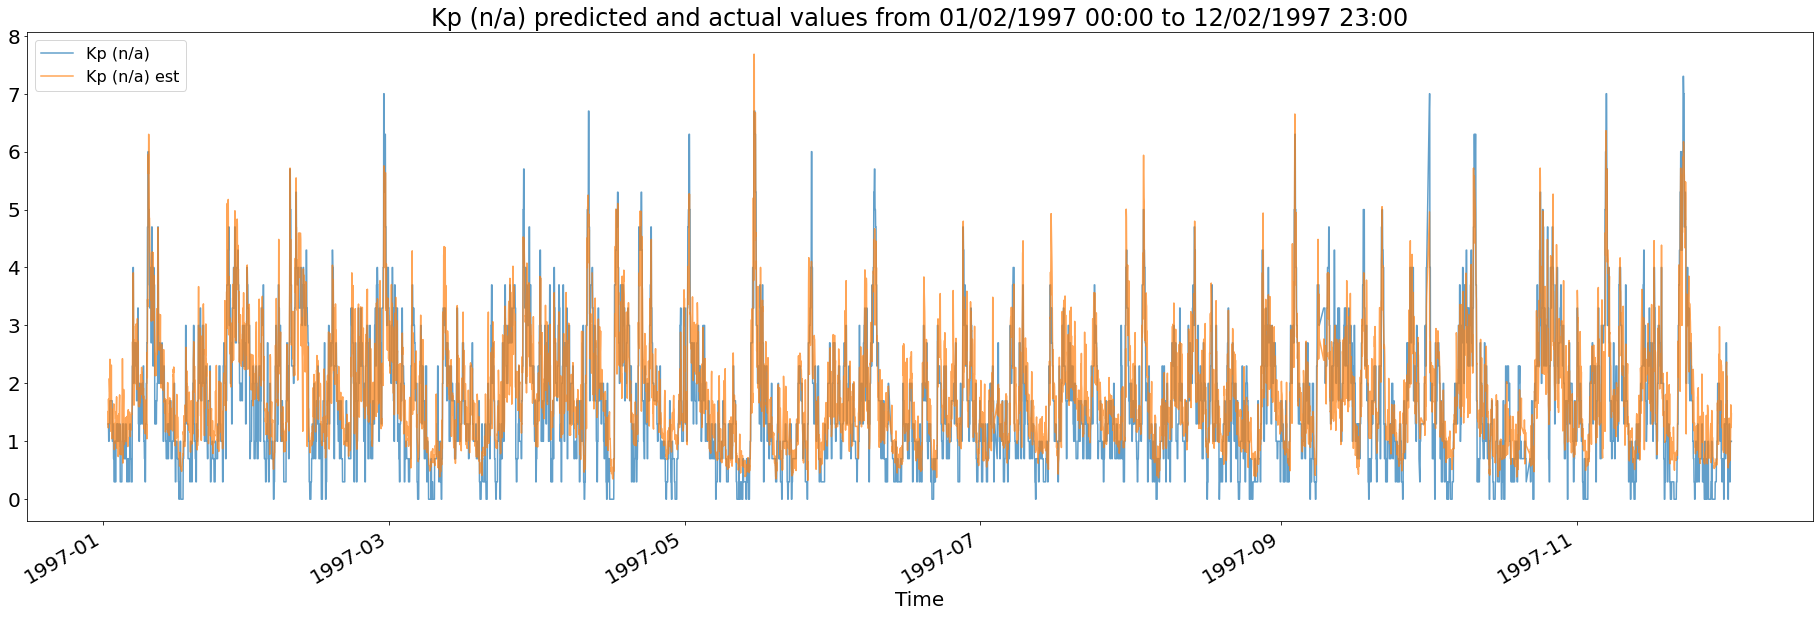

In [16]:
plt.figure(figsize=(32,10))

time_interval = (datetime(1997, 1, 2, 0, 0),datetime(1997, 12, 2, 23, 0)) # Configurable datetime(year, month, day, hour, min)
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

testing_data.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7) # alpha to set opacity
testing_data.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-320,100))

plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+time_interval[0].strftime('%m/%d/%Y %H:%M')+' to '+time_interval[1].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

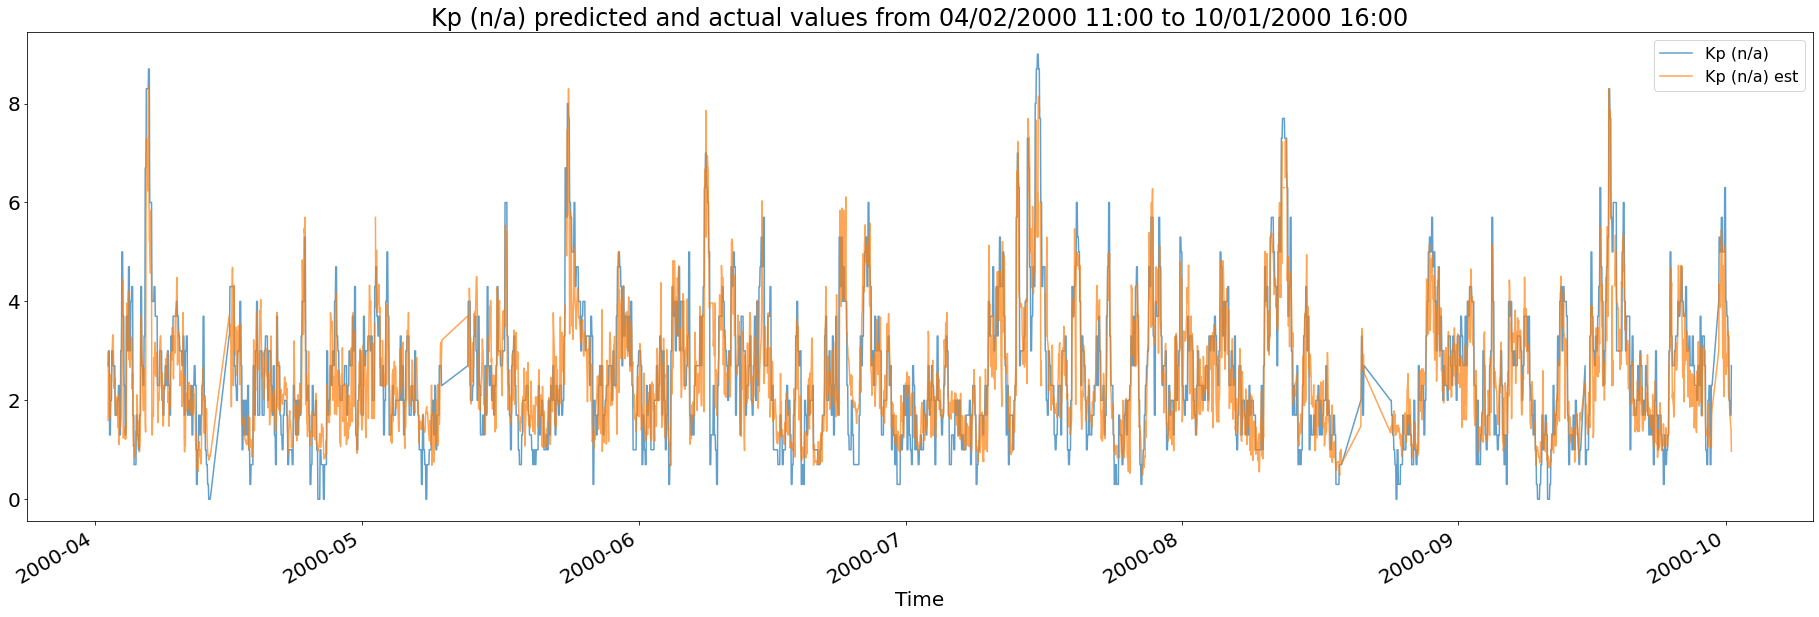

In [17]:
plt.figure(figsize=(32,10))

time_interval = (32400,36500) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

testing_data.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7)
testing_data.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-320,100))

plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+testing_data['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+testing_data['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

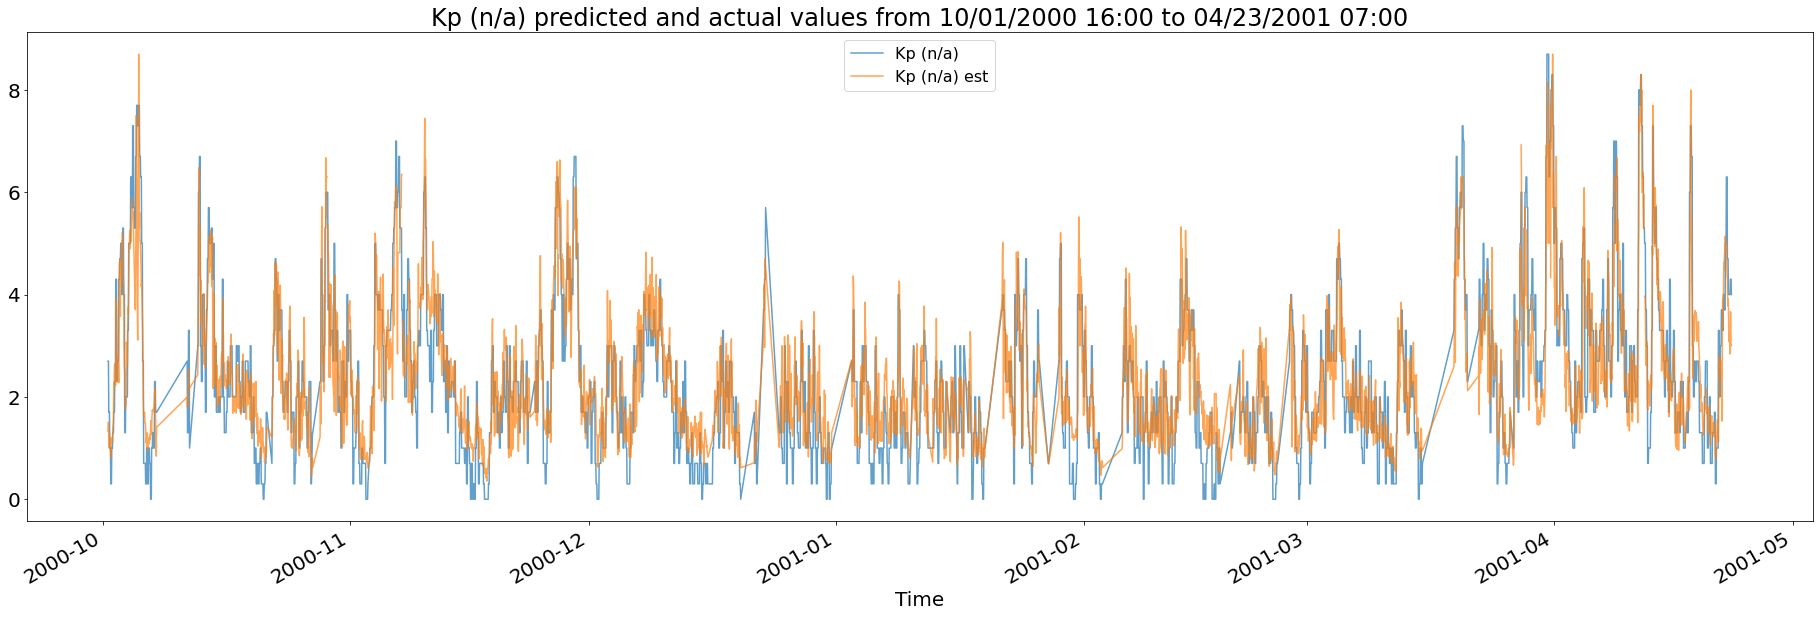

In [18]:
plt.figure(figsize=(32,10))

time_interval = (36500,40600) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

testing_data.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot(alpha=0.7)
testing_data.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot(alpha=0.7)

#plt.ylim((-420,100))

plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+testing_data['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+testing_data['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()

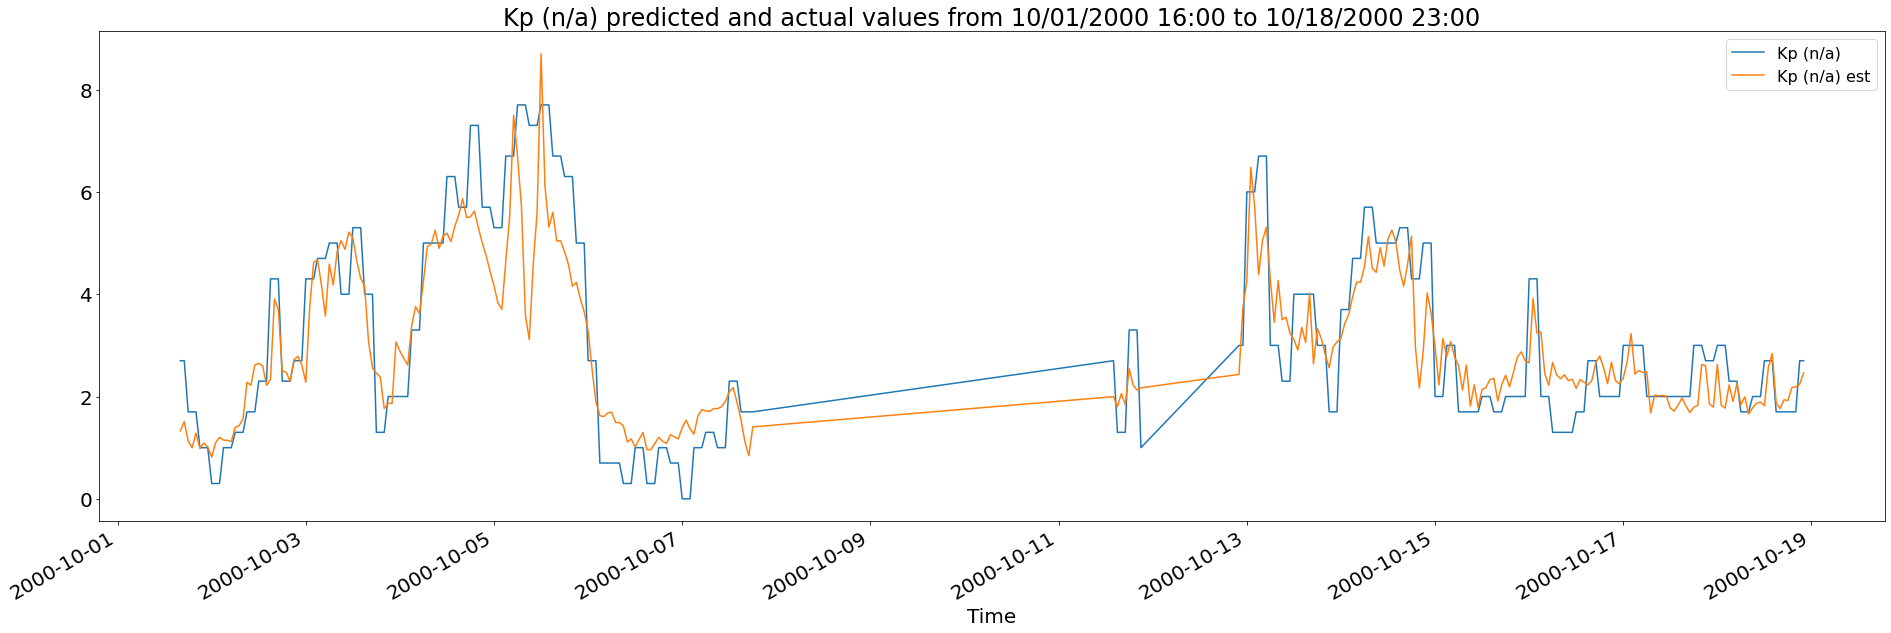

In [19]:
plt.figure(figsize=(32,10))

time_interval = (36500,36800) # By index
# Due to nature of Python slicing, the first datetime inclusive and second datetime exclusive

testing_data.set_index('datetime')[MATCH][time_interval[0]:time_interval[1]].plot()
testing_data.set_index('datetime')[MATCH + ' est'][time_interval[0]:time_interval[1]].plot()

#plt.ylim((-420,100))

plt.xlabel('Time')
plt.title(MATCH+' predicted and actual values from '+testing_data['datetime'].iloc[time_interval[0]].strftime('%m/%d/%Y %H:%M')+' to '+testing_data['datetime'].iloc[time_interval[1]].strftime('%m/%d/%Y %H:%M'))
plt.legend()
plt.show()